In [ ]:
import jittor as jt
import jittor.nn as nn
from jittor import dataset
from jittor.dataset.mnist import MNIST
from jittor import transform
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa:F401

[i 0626 10:24:57.588649 88 compiler.py:851] Jittor(1.2.2.59) src: /usr/local/lib/python3.7/dist-packages/jittor
[i 0626 10:24:57.589417 88 compiler.py:852] g++ at /usr/bin/g++
[i 0626 10:24:57.589906 88 compiler.py:853] cache_path: /root/.cache/jittor/default/g++
[i 0626 10:24:57.599599 88 __init__.py:257] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0626 10:24:57.621319 88 compiler.py:893] pybind_include: -I/usr/include/python3.7m -I/usr/local/lib/python3.7/dist-packages/pybind11/include
[i 0626 10:24:57.631580 88 compiler.py:895] extension_suffix: .cpython-37m-x86_64-linux-gnu.so
[i 0626 10:24:57.770161 88 __init__.py:169] Total mem: 15.49GB, using 5 procs for compiling.
[i 0626 10:24:57.897332 88 jit_compiler.cc:21] Load cc_path: /usr/bin/g++
[i 0626 10:24:58.017162 88 __init__.py:257] Found mpicc(2.1.1) at /usr/bin/mpicc.
[i 0626 10:24:58.032306 88 compiler.py:658] handle pyjt_include/usr/local/lib/python3.7/dist-packages/jittor/extern/mpi/inc/mpi_warper.h


## linear

In [ ]:
#自定义Linear算子
class LinearFunction(jt.Function):
    def execute(self,x,W,b):
        self.x = x
        self.W = W
        #线性前向: y=xW+b
        out = jt.matmul(x,W)+b
        return out

    def grad(self,grad_out):
        #反向传播：手动求导
        dx = jt.matmul(grad_out,jt.transpose(self.W))        
        dW = jt.matmul(jt.transpose(self.x),grad_out) 
        db = grad_out.sum(0)
        return dx,dW,db

class Linear(jt.Module):
    def __init__(self,in_features,out_features):
        self.weight = jt.randn(in_features,out_features)    #随机初始化权重
        self.bias = jt.zeros(out_features)                  #偏置初始化为0

    def execute(self,x):
        return LinearFunction.apply(x,self.weight,self.bias)

## relu

In [ ]:
#自定义ReLU算子
class ReLUFunction(jt.Function):
    def execute(self,x):
        self.x = x
        return jt.maximum(x,0)   #ReLU前向

    def grad(self,grad_out):
        #梯度仅保留正值
        return grad_out*(self.x>0)

class ReLU(jt.Module):
    def execute(self,x):
        return ReLUFunction.apply(x)

## sigmoid

In [ ]:
#自定义Sigmoid算子
class SigmoidFunction(jt.Function):
    def execute(self,x):
        self.y=1/(1+jt.exp(-x))
        return self.y

    def grad(self,grad_out):
        return grad_out*self.y*(1-self.y)

class Sigmoid(jt.Module):
    def execute(self,x):
        return SigmoidFunction.apply(x)

## MSE loss

In [ ]:
#自定义MSE Loss算子
class MSELossFunction(jt.Function):
    def execute(self,pred,target):
        self.pred = pred
        self.target = target
        return ((pred-target)**2).mean()

    def grad(self,grad_out):
        N = self.pred.shape[0]
        grad_pred = grad_out*2*(self.pred-self.target)/N
        return grad_pred,None

class MSELoss(jt.Module):
    def execute(self,pred,target):
        return MSELossFunction.apply(pred,target)

## softmax

In [ ]:
#自定义Softmax算子
class SoftmaxFunction(jt.Function):
    def execute(self,x):
        #为避免数值溢出，减去每行最大值
        x_max = x.max(dim=1,keepdims=True)
        ex = jt.exp(x-x_max)
        sum_ex = ex.sum(dim=1,keepdims=True)
        self.out = ex/sum_ex
        return self.out

    def grad(self,grad_out):
        s = self.out
        gs = (grad_out*s).sum(dim=1,keepdims=True)
        return s*(grad_out-gs)

class Softmax(jt.Module):
    def execute(self,x):
        return SoftmaxFunction.apply(x)

## cross entrophy loss

In [ ]:
def my_one_hot(labels,num_classes):
    """
    将标签转换为one-hot编码
    labels:[B],int类型
    返回:[B,num_classes],float32 one-hot矩阵
    """
    B = labels.shape[0]
    one_hot = jt.zeros((B,num_classes)).float32()
    src = jt.ones((B,1)).float32()
    one_hot = one_hot.scatter(1,labels.unsqueeze(1),src)
    return one_hot

In [ ]:
class CrossEntropyLossFunction(jt.Function):
    def execute(self,logits,target):
        self.target = target
        self.logits = logits

        logits_max = logits.max(dim=1,keepdims=True)
        logits_stable = logits-logits_max       #防止指数爆炸
        exp_logits = jt.exp(logits_stable)
        sum_exp = exp_logits.sum(dim=1,keepdims=True)
        self.log_softmax = logits_stable-jt.log(sum_exp+1e-9)

        target_log_probs = self.log_softmax.gather(1,target.unsqueeze(1)).squeeze(1)
        loss = -target_log_probs.mean()
        return loss

    def grad(self,grad_out):
        B, C = self.logits.shape
        target_onehot = my_one_hot(self.target,C) 
        #grad_logits = (self.probs-target_onehot)/B
        grad_logits = (jt.exp(self.log_softmax)-target_onehot)/B
        return grad_out*grad_logits,None

class CrossEntropyLoss(jt.Module):
    def execute(self,logits,target):
        return CrossEntropyLossFunction.apply(logits,target)


## task1

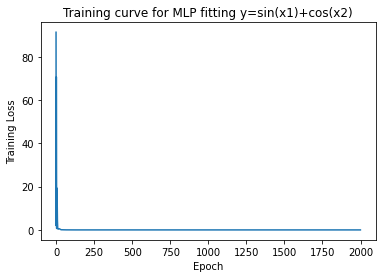

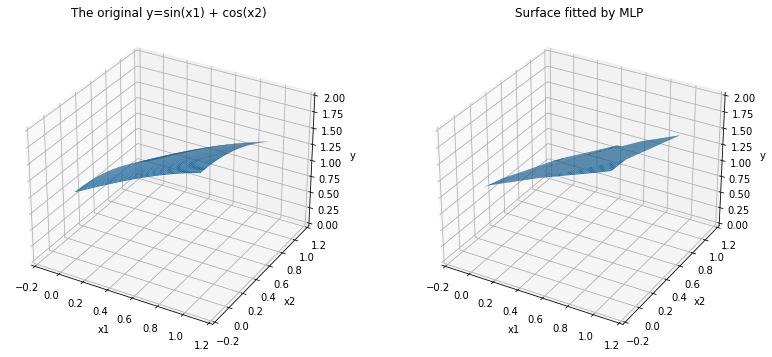

MSE_loss= 0.001475769910030067
True vs Pred (samples):
y_true=1.533, y_pred=1.527
y_true=0.996, y_pred=0.983
y_true=1.528, y_pred=1.527
y_true=0.968, y_pred=0.939
y_true=1.190, y_pred=1.161
y_true=0.972, y_pred=0.990
y_true=1.446, y_pred=1.386
y_true=1.203, y_pred=1.157
y_true=1.160, y_pred=1.115
y_true=1.113, y_pred=1.117


In [ ]:
class MLPRegressor(jt.Module):
    def __init__(self):
        self.fc1 = Linear(2,64)
        self.relu = ReLU()
        self.fc2 = Linear(64,1)

    def execute(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#生成训练数据
N = 1000
X_np = np.random.rand(N,2).astype(np.float32)
Y_np = np.sin(X_np[:,0:1])+np.cos(X_np[:,1:2])

#边缘加密采样
M = 200
edge1 = np.stack([np.zeros(M),np.random.rand(M)],axis=1)
edge2 = np.stack([np.ones(M),np.random.rand(M)],axis=1)
edge3 = np.stack([np.random.rand(M),np.zeros(M)],axis=1)
edge4 = np.stack([np.random.rand(M),np.ones(M)],axis=1)
X_edges = np.vstack([edge1,edge2,edge3,edge4]).astype(np.float32)
Y_edges = np.sin(X_edges[:,0:1])+np.cos(X_edges[:,1:2])

#合并
X_np = np.vstack([X_np,X_edges])
Y_np = np.vstack([Y_np,Y_edges])
X = jt.array(X_np)
Y = jt.array(Y_np)

model = MLPRegressor()
mse_loss = MSELoss()
optimizer = jt.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

#训练
num_epochs = 2000
loss_history = []
for epoch in range(num_epochs):
    pred = model(X)                         #前向
    loss = mse_loss(pred,Y)                 #计算损失
    optimizer.step(loss)                    #反向+更新参数
    loss_history.append(loss.item())

#损失曲线图
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training curve for MLP fitting y=sin(x1)+cos(x2)")
plt.show()

#可视化效果图
grid_size = 50
x1 = np.linspace(0,1,grid_size)
x2 = np.linspace(0,1,grid_size)
X1, X2 = np.meshgrid(x1,x2)
X_grid = np.stack([X1.ravel(),X2.ravel()],axis=1).astype(np.float32)
Y_true = np.sin(X_grid[:,0:1])+np.cos(X_grid[:,1:2])
Y_pred = model(jt.array(X_grid)).data

Y_true_grid = Y_true.reshape(grid_size,grid_size)
Y_pred_grid = Y_pred.reshape(grid_size,grid_size)
fig = plt.figure(figsize=(12,5))

# 原函数曲面
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.plot_surface(X1,X2,Y_true_grid)
ax1.set_title("The original y=sin(x1)+cos(x2)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_zlabel("y")
ax1.set_xlim(-0.2,1.2)
ax1.set_ylim(-0.2,1.2)
ax1.set_zlim(0,2.0)

# 拟合后曲面
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.plot_surface(X1,X2,Y_pred_grid)
ax2.set_title("Surface fitted by MLP")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("y")
ax2.set_xlim(-0.2,1.2)
ax2.set_ylim(-0.2,1.2)
ax2.set_zlim(0,2.0)

plt.tight_layout()
plt.show()

print("MSE_loss=",mse_loss(model(X),Y).item())

pred_vals = model(X).data
print("True vs Pred (samples):")
for i in range(10):
    print(f"y_true={Y_np[i,0]:.3f}, y_pred={pred_vals[i,0]:.3f}")

## task2

Epoch 1, Loss = 0.9834 | Test Accuracy: 0.8419
Epoch 2, Loss = 0.4706 | Test Accuracy: 0.8788
Epoch 3, Loss = 0.3869 | Test Accuracy: 0.9004
Epoch 4, Loss = 0.3393 | Test Accuracy: 0.9109
Epoch 5, Loss = 0.3073 | Test Accuracy: 0.9158
Epoch 6, Loss = 0.2821 | Test Accuracy: 0.9236
Epoch 7, Loss = 0.2619 | Test Accuracy: 0.9266
Epoch 8, Loss = 0.2456 | Test Accuracy: 0.9315
Epoch 9, Loss = 0.2319 | Test Accuracy: 0.9347
Epoch 10, Loss = 0.2199 | Test Accuracy: 0.9376
Epoch 11, Loss = 0.2084 | Test Accuracy: 0.9382
Epoch 12, Loss = 0.2007 | Test Accuracy: 0.9419
Epoch 13, Loss = 0.1902 | Test Accuracy: 0.9448
Epoch 14, Loss = 0.1821 | Test Accuracy: 0.9454
Epoch 15, Loss = 0.1746 | Test Accuracy: 0.9471
Epoch 16, Loss = 0.1686 | Test Accuracy: 0.9464
Epoch 17, Loss = 0.1625 | Test Accuracy: 0.9497
Epoch 18, Loss = 0.1567 | Test Accuracy: 0.9517
Epoch 19, Loss = 0.1517 | Test Accuracy: 0.9513
Epoch 20, Loss = 0.1458 | Test Accuracy: 0.9532
Epoch 21, Loss = 0.1414 | Test Accuracy: 0.9527
E

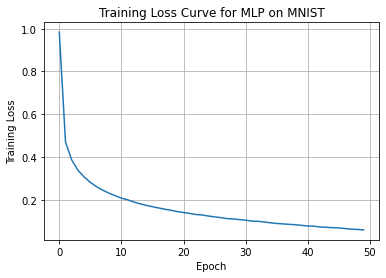

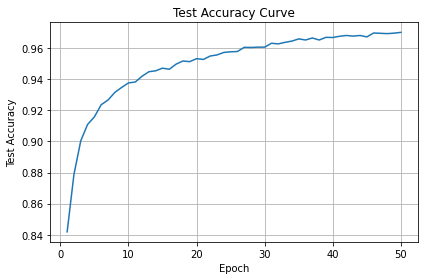

In [ ]:
mnist_transform = transform.Compose([transform.ToTensor()])     #转float32 Tensor且归一化

train_loader = MNIST(train=True,transform=mnist_transform).set_attrs(batch_size=128,shuffle=True)
test_loader  = MNIST(train=False,transform=mnist_transform).set_attrs(batch_size=1000,shuffle=False)

class MLPClassifier(jt.Module):
    def __init__(self):
        in_dim = 3*28*28       #憋笑
        self.fc1 = Linear(in_dim,128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = ReLU()
        self.fc2 = Linear(128,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = ReLU()
        self.fc3 = Linear(64,10)

    def execute(self,x):
        x = x.view(x.shape[0],-1)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        return self.fc3(x)

model = MLPClassifier()
celoss = CrossEntropyLoss()
optimizer = jt.optim.SGD(model.parameters(),lr=0.03,momentum=0.9,weight_decay=1e-4)

# 训练
loss_history = []
acc_history= []
num_of_epochs = 50
for epoch in range(num_of_epochs):
    model.train()
    total_loss = 0.0
    for i,(imgs,labels) in enumerate(train_loader):
        outputs = model(imgs)
        loss = celoss(outputs,labels)
        optimizer.step(loss)
        total_loss += loss.item()
    avg_loss = total_loss/(i+1)
    loss_history.append(avg_loss)
    #print(f"Epoch {epoch+1}, Loss = {avg_loss:.4f}|")
    
    model.eval()
    correct = 0
    total = 0

    with jt.no_grad():
        for imgs,labels in test_loader:
            labels_np = np.array(labels)

            outputs = model(imgs)
            if not isinstance(outputs,jt.Var):
                outputs = jt.stack(outputs)

            preds = outputs.argmax(dim=1)
            if not isinstance(preds,jt.Var):
                preds = jt.stack(preds)

            preds_np = np.array(preds)

            batch_correct = np.sum(preds_np==labels_np)
            correct += batch_correct
            total += labels_np.shape[0]

    print(f"Epoch {epoch+1}, Loss = {avg_loss:.4f} | Test Accuracy: {correct/total:.4f}")
    acc_history.append(correct/total)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve for MLP on MNIST")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1,num_of_epochs+1),acc_history)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

